In [22]:
# Imports
import os
import tensorflow as tf
import math
import matplotlib.pyplot as plt



from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

There are number of hyperparameters we have to tune while training a deep neural network, such as 
1. Learning rate
2. Momentum or the hyperparameters for Adam optimization algorithm
3. Number of layers
4. Number of hidden units
5. Mini-batch size
6. Activation function

Among them, the most important parameter is the learning rate. If your learning rate is set to low, training will progress very slowly as you are making very tiny updates to the weights in your network. However, if your learning rate is set too high, it can cause undesirable divergent behavior in your loss function.

![Pic1](Module5Pic1.png)

When training a neural network, it is often useful to reduce the learning rate as the training progresses. This can be done by using learning rate schedules or adaptive learning rate. **` LearningRateScheduler`** is a built-in callback for learning rate schedules.

***

### LearningRateScheduler

This callback is handy in scenarios where the user wants to update the learning rate as training progresses. For instance, as the training progresses you may want to decrease the learning rate after a certain number of epochs. The `LearningRateScheduler` will let you do exactly that.

```
tf.keras.callbacks.LearningRateScheduler(schedule, verbose=0)
```

**schedule:** this is a function that takes the epoch index and returns a new learning rate.

**verbose:** whether or not to print additional logs.

***

***
**Learning Rate Schedules** seek to adjust the learning rate during training by reducing the learning rate according to a pre-defined schedule. The popular learning rate schedules include
1. Constant learning rate
2. Time-based decay
3. Step decay
4. Exponential decay

For the demonstration purpose, we will build an image classifier to tackle Fashion MNIST, which is a dataset that has 70,000 grayscale images of 28-by-28 pixels with 10 classes.

***
## Preparing Dataset 

***

In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_labels = train_labels[:1000]
test_labels = test_labels[:1000]

train_images = train_images[:1000].reshape(-1, 28 * 28) / 255.0
test_images = test_images[:1000].reshape(-1, 28 * 28) / 255.0

11493376/11490434 [==============================] - 0s 0us/step


## Define the Model

In [4]:
# Define a simple sequential model
def create_model():
  model = Sequential([
    Dense(512, activation='relu', input_shape=(784,), name = 'Layer-1'),
    Dropout(0.2),
    Dense(10, name = "Layer-2")
  ])

  model.compile(optimizer='adam',
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[tf.metrics.SparseCategoricalAccuracy()])

  return model

# Create a basic model instance
model = create_model()

# Display the model's architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Layer-1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
Layer-2 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


### 1. Constant learning rate

The constant learning rate is the default schedule in all Keras Optimizers. For example, in the SGD optimizer, the learning rate defaults to $0.01$.

To use a custom learning rate, simply instantiate an SGD optimizer and pass the argument learning_rate=0.01 .

In [7]:
# Train the model with the new callback
history = model.fit(train_images, 
          train_labels,  
          epochs=50,
          validation_data=(test_images, test_labels))  # Pass callback to training

Epoch 1/50
32/32 [==============================] - 0s 8ms/step - loss: 7.7243e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.5059 - val_sparse_categorical_accuracy: 0.8720
Epoch 2/50
32/32 [==============================] - 0s 6ms/step - loss: 7.1143e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.5056 - val_sparse_categorical_accuracy: 0.8730
Epoch 3/50
32/32 [==============================] - 0s 7ms/step - loss: 5.6393e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.5081 - val_sparse_categorical_accuracy: 0.8720
Epoch 4/50
32/32 [==============================] - 0s 6ms/step - loss: 7.1163e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.5063 - val_sparse_categorical_accuracy: 0.8740
Epoch 5/50
32/32 [==============================] - 0s 9ms/step - loss: 5.8590e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.5072 - val_sparse_categorical_accuracy: 0.8740
Epoch 6/50
32/32 [==============================] - 0s 8ms/step - loss: 6.2395e-04 - spars

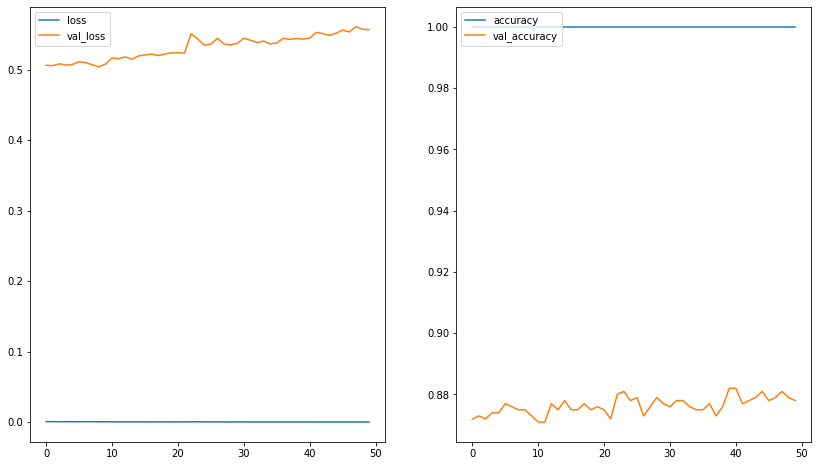

In [10]:
plt.figure(figsize = (14, 8))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['sparse_categorical_accuracy'],label='accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='val_accuracy')
plt.legend(loc='upper left')
plt.show()

***

### 2. Time-based decay

Time-based decay is one of the most popular learning rate schedules. Formally, the time-based decay is defined as:

\begin{equation}
learning_rate = lr * \frac{1}{(1 + decay * epoch)}
\end{equation}

where $lr$ is the previous learning rate, decay is a hyperparameter and epoch is the iteration number. 

When the decay is zero, this has no effect on changing the learning rate. When the decay is specified, it will decrease the learning rate from the previous epoch by the given fixed amount. The value of decay is normally implemented as

\begin{equation}
decay = \frac{initial\ learning\ rate}{num \ of\ epoches} 
\end{equation}

In Keras, one way to implement the time-based decay is by defining a time-based decay function `lr_time_based_decay()` and pass it to `LearningRateScheduler` callback.

In [16]:
initial_learning_rate = 0.01
epochs = 100
decay = initial_learning_rate/epochs

def lr_time_based_decay(epoch, lr):
  lr = lr * 1/(1+decay*epoch)
  return lr

In [18]:
history1 = model.fit(train_images, 
          train_labels,  
          epochs=100,
          validation_data=(test_images, test_labels),
          callbacks = [tf.keras.callbacks.LearningRateScheduler(lr_time_based_decay, verbose = 1)])  # Pass callback to training

Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
32/32 [==============================] - 0s 8ms/step - loss: 1.6661e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.5558 - val_sparse_categorical_accuracy: 0.8770
Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0009999000574917021.
32/32 [==============================] - 0s 7ms/step - loss: 1.7199e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.5594 - val_sparse_categorical_accuracy: 0.8780
Epoch 3/100

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000999700106714659.
32/32 [==============================] - 0s 7ms/step - loss: 1.4075e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.5603 - val_sparse_categorical_accuracy: 0.8760
Epoch 4/100

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0009994003415259673.
32/32 [==============================] - 0s 7ms/step - loss: 1.6281e-04 - sparse_categorical_accurac

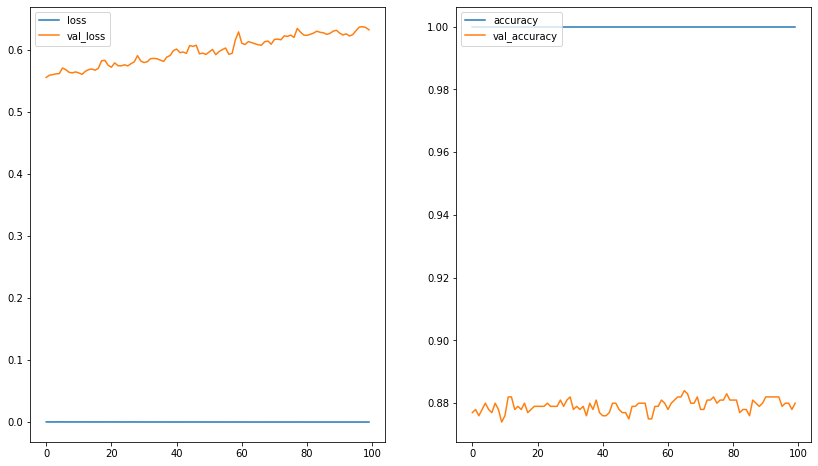

In [19]:
plt.figure(figsize = (14, 8))
plt.subplot(1,2,1)
plt.plot(history1.history['loss'], label='loss')
plt.plot(history1.history['val_loss'], label='val_loss')
plt.legend(loc='upper left')

plt.subplot(1,2,2)
plt.plot(history1.history['sparse_categorical_accuracy'],label='accuracy')
plt.plot(history1.history['val_sparse_categorical_accuracy'], label='val_accuracy')
plt.legend(loc='upper left')
plt.show()

***
### Step decay

Another popular learning rate schedule is to systematically drop the learning rate at specific times during training. Formally, it is defined as:
\begin{equation}
learning_rate = initial\_lr * drop\_rate^{\lfloor\frac{epoch}{ epochs\_drop}\rfloor}
\end{equation}

Where $initial\_lr$ is the initial learning rate such as $0.01$, the $drop\_rate$ is the amount that the learning rate is modified each time if it is changed, epoch is the current epoch number, and $epochs\_drop$ is how often to change the learning rate such as $10$ epochs. Similarly, we can implement this by defining a step decay function `lr_step_decay()` and pass it to `LearningRateScheduler` callback.

In [20]:
nitial_learning_rate = 0.01
def lr_step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 10.0
    return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))

In [23]:
history = model.fit(train_images, 
          train_labels,  
          epochs=100,
          validation_data=(test_images, test_labels),
          callbacks = [tf.keras.callbacks.LearningRateScheduler(lr_step_decay, verbose = 1)])  # Pass callback to training

Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
32/32 [==============================] - 0s 7ms/step - loss: 2.6359 - sparse_categorical_accuracy: 0.9140 - val_loss: 4.4453 - val_sparse_categorical_accuracy: 0.5880
Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 0.01.
32/32 [==============================] - 0s 7ms/step - loss: 1.5726 - sparse_categorical_accuracy: 0.7410 - val_loss: 0.9850 - val_sparse_categorical_accuracy: 0.7160
Epoch 3/100

Epoch 00003: LearningRateScheduler reducing learning rate to 0.01.
32/32 [==============================] - 0s 7ms/step - loss: 0.6297 - sparse_categorical_accuracy: 0.8380 - val_loss: 0.8954 - val_sparse_categorical_accuracy: 0.7530
Epoch 4/100

Epoch 00004: LearningRateScheduler reducing learning rate to 0.01.
32/32 [==============================] - 0s 7ms/step - loss: 0.3856 - sparse_categorical_accuracy: 0.8910 - val_loss: 0.8843 - val_sparse_categorical_accuracy: 0.7850
Epoch 5/100


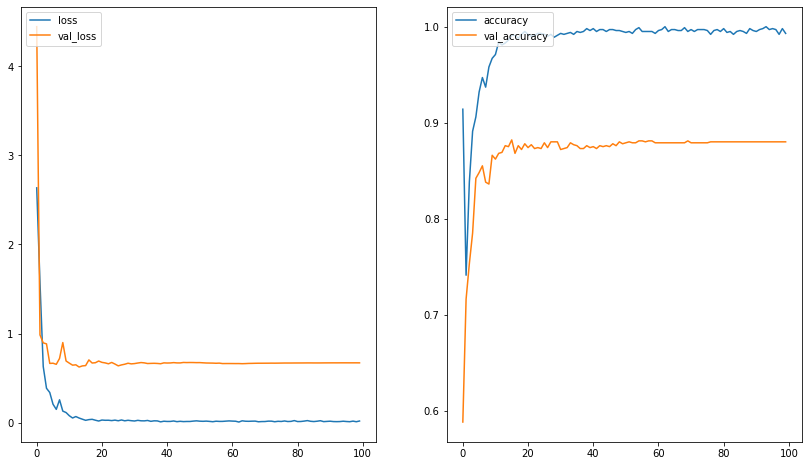

In [24]:
plt.figure(figsize = (14, 8))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['sparse_categorical_accuracy'],label='accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='val_accuracy')
plt.legend(loc='upper left')
plt.show()

***
### Exponential decay
Another popular learning rate schedule is to drop the learning rate at an exponential rate. Formally, it is defined as:
\begin{equation}
learning\_rate = initial\_lr * e^{(−k * epoch)}
\end{equation}
Where $initial\_lr$ is the initial learning rate such as $0.01$, $k$ is a hyperparameter, and epoch is the current epoch number. Similarly, we can implement this by defining an exponential decay function `lr_exp_decay()` and pass it to `LearningRateScheduler` callback.

In [25]:
initial_learning_rate = 0.01
def lr_exp_decay(epoch, lr):
    k = 0.1
    return initial_learning_rate * math.exp(-k*epoch)

In [26]:
history = model.fit(train_images, 
          train_labels,  
          epochs=100,
          validation_data=(test_images, test_labels),
          callbacks = [tf.keras.callbacks.LearningRateScheduler(lr_exp_decay, verbose = 1)])  # Pass callback to training

Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
32/32 [==============================] - 0s 13ms/step - loss: 0.0163 - sparse_categorical_accuracy: 0.9970 - val_loss: 0.7712 - val_sparse_categorical_accuracy: 0.8740
Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009048374180359595.
32/32 [==============================] - 0s 9ms/step - loss: 0.0385 - sparse_categorical_accuracy: 0.9870 - val_loss: 0.7204 - val_sparse_categorical_accuracy: 0.8810
Epoch 3/100

Epoch 00003: LearningRateScheduler reducing learning rate to 0.008187307530779819.
32/32 [==============================] - 0s 8ms/step - loss: 0.0528 - sparse_categorical_accuracy: 0.9840 - val_loss: 0.9190 - val_sparse_categorical_accuracy: 0.8680
Epoch 4/100

Epoch 00004: LearningRateScheduler reducing learning rate to 0.007408182206817179.
32/32 [==============================] - 0s 7ms/step - loss: 0.1211 - sparse_categorical_accuracy: 0.9700 - val_loss: 0.7516 - val

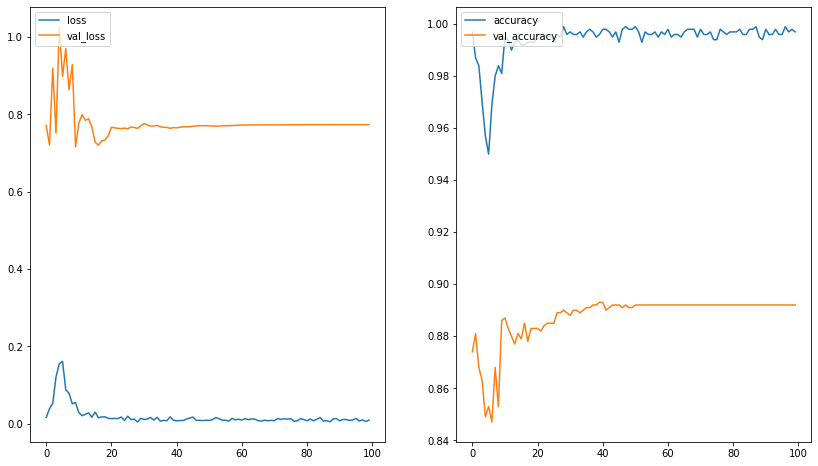

In [27]:
plt.figure(figsize = (14, 8))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['sparse_categorical_accuracy'],label='accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='val_accuracy')
plt.legend(loc='upper left')
plt.show()

# References

1. [A Guide to TensorFlow Callbacks](https://blog.paperspace.com/tensorflow-callbacks/)
2. [Writing your own callbacks](https://www.tensorflow.org/guide/keras/custom_callback)
3. [tf.keras.callbacks.Callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback)
4. [A Practical Introduction to Keras Callbacks in TensorFlow 2](https://towardsdatascience.com/a-practical-introduction-to-keras-callbacks-in-tensorflow-2-705d0c584966)
5. [How to use TensorFlow callbacks?](https://medium.com/ydata-ai/how-to-use-tensorflow-callbacks-f54f9bb6db25)
6. [Callbacks in Tensor Flow](https://sailajakarra.medium.com/callbacks-in-tensor-flow-f8e7f9996f5f)
7. [Keras Callbacks Explained In Three Minutes](https://www.kdnuggets.com/2019/08/keras-callbacks-explained-three-minutes.html)
8. [Learning Rate Schedule in Practice: an example with Keras and TensorFlow 2.0](https://towardsdatascience.com/learning-rate-schedule-in-practice-an-example-with-keras-and-tensorflow-2-0-2f48b2888a0c)
